# Modelamiento Machine Learning - Region Valparaiso

Carga de librerias y datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
Inmuebles = pd.read_csv(r'C:\Users\sebit\OneDrive\Documentos\Portafolio\Analisis Casas Valparaiso\Datos ML Valparaiso.csv')

In [21]:
print(Inmuebles.info())
print(Inmuebles.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Precio UF                  961 non-null    float64
 1   N Habitaciones             961 non-null    float64
 2   N Baños                    961 non-null    float64
 3   Comuna                     961 non-null    object 
 4   Provincia                  961 non-null    object 
 5   Amueblado                  499 non-null    object 
 6   Estacionamiento            961 non-null    int64  
 7   Año de construcción        384 non-null    float64
 8   Aire Acondicionado         961 non-null    int64  
 9   Alarma                     961 non-null    int64  
 10  Bodega                     961 non-null    int64  
 11  Chimenea                   961 non-null    int64  
 12  Placares                   961 non-null    int64  
 13  Cocina Equipada            961 non-null    int64  

### Separacion train y test 


In [22]:
# Seleccion columnas 
Categoricas = Inmuebles.select_dtypes(include=['object']).columns.tolist()
Numericas = Inmuebles.select_dtypes(include=['float64']).columns.tolist()
if 'Precio UF' in Numericas:
    Numericas.remove('Precio UF')
Binarias = Inmuebles.select_dtypes(include=['int64']).columns.tolist()

In [23]:
# Division de precios en 5 niveles para separacion
Inmuebles['Precio Bin'] = pd.qcut(
    Inmuebles['Precio UF'], 
    q=5, 
    labels=False,          
    duplicates='drop'
)

# 2. CREAR LLAVE ESTRATIFICADA (Precio + Comuna)

Inmuebles['Stratify Key'] = (
    Inmuebles['Precio Bin'].astype(str) + '_' + 
    Inmuebles['Comuna'].astype(str)
)

stratify_counts = Inmuebles['Stratify Key'].value_counts()

# Si una combinacion tiene menos de casas, es riesgoso usarla.
if (stratify_counts <= 5).any():
    stratify_col = Inmuebles['Comuna']
else:
    stratify_col = Inmuebles['Stratify Key']

# División de Datos
X = Inmuebles.drop(['Precio UF', 'Precio Bin', 'Stratify Key'], axis=1)
y = Inmuebles['Precio UF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=stratify_col )



Una caracteristica util es Precio/m2 por comuna mediano pero con el fin de no hacer data leak se crea solo para training.

In [24]:
# 2. Calculas la mediana SOLO en training
precio_m2_train = y_train / X_train['Area Terreno']
medianas_por_comuna = precio_m2_train.groupby(X_train['Comuna']).median()

# 3. Creas la feature en train usando sus propias medianas
X_train['Precio m2 Comuna Mediano'] = X_train['Comuna'].map(medianas_por_comuna)

# 4. Creas la feature en test usando las medianas DEL TRAIN
X_test['Precio m2 Comuna Mediano'] = X_test['Comuna'].map(medianas_por_comuna)

### Pipeline y Preprocesado para modelos que no permiten valores NaN

In [25]:
# Pipeline Numerico
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

# Pipeline Categorico 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, Numericas),
        ('cat', categorical_transformer, Categoricas),
        ('bin', 'passthrough', Binarias)  # Las binarias pasan tal cual
    ],
    remainder='drop'  # Elimina columnas no especificadas
)

In [26]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Diccionario de modelos a probar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=1, n_jobs=-1)
}

# Almacenar resultados
results = []

for name, model in models.items():
    print("-"*80)
    print(f" {name}")
    
    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Cross-validation (más robusto que un solo train/test)
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,  # 5 folds
        scoring='r2',
        n_jobs=-1
    )
    
    # Entrenar en todo el train
    pipeline.fit(X_train, y_train)
    
    # Evaluar en test
    y_pred = pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    # Guardar resultados
    results.append({
        'Modelo': name,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std(),
        'Test R²': test_r2,
        'Test MAE': test_mae
    })
    
    print(f"Validacion Cruzada R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"Prueba R²: {test_r2:.4f}")
    print(f"Prueba MAE: {test_mae:.2f} UF")

--------------------------------------------------------------------------------
 Linear Regression
Validacion Cruzada R²: 0.4557 (+/- 0.1707)
Prueba R²: 0.5106
Prueba MAE: 3416.86 UF
--------------------------------------------------------------------------------
 Ridge
Validacion Cruzada R²: 0.4628 (+/- 0.1675)
Prueba R²: 0.5156
Prueba MAE: 3403.78 UF
--------------------------------------------------------------------------------
 Lasso
Validacion Cruzada R²: 0.4581 (+/- 0.1696)
Prueba R²: 0.5127
Prueba MAE: 3405.69 UF
--------------------------------------------------------------------------------
 Random Forest
Validacion Cruzada R²: 0.5859 (+/- 0.0745)
Prueba R²: 0.6360
Prueba MAE: 2786.05 UF
--------------------------------------------------------------------------------
 Gradient Boosting
Validacion Cruzada R²: 0.6167 (+/- 0.0706)
Prueba R²: 0.6599
Prueba MAE: 2688.93 UF
--------------------------------------------------------------------------------
 XGBoost
Validacion Cruzada

Mejor modelo a entrenar Gradient Boosting

### Ajustes de hiperparametros Gradient Boost

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

Mejor_Modelo = GradientBoostingRegressor(random_state=1)

param_distributions = {
    'model__n_estimators': np.arange(100,1000,100),
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [2, 3, 4, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Mejor_Modelo)
])

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=40,
    cv=5,
    scoring={
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error'
    },
    refit='mae',         # optimizamos para MAE
    n_jobs=-1,
    random_state=1,
    verbose=2,
    return_train_score=True
)

random_search.fit(X_train, y_train)

# Índice del mejor set de hiperparámetros
best_idx = random_search.best_index_

# Extraer métricas de CV para ese índice
cv_mae = -random_search.cv_results_['mean_test_mae'][best_idx]   # poner positivo
cv_r2  =  random_search.cv_results_['mean_test_r2'][best_idx]

print("Mejores parámetros:")
print(random_search.best_params_)

print(f"CV MAE (optimizado): {cv_mae:.2f} UF")
print(f"CV R² (del modelo con mejor MAE): {cv_r2:.4f}")

# Evaluación en test
y_optimizado = random_search.predict(X_test)

test_r2_optimized = r2_score(y_test, y_optimizado)
test_mae_optimized = mean_absolute_error(y_test, y_optimizado)

print(f"Prueba R²: {test_r2_optimized:.4f}")
print(f"Prueba MAE: {test_mae_optimized:.2f} UF")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros:
{'model__subsample': 0.8, 'model__n_estimators': np.int64(700), 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 4, 'model__learning_rate': 0.03}
CV MAE (optimizado): 2740.18 UF
CV R² (del modelo con mejor MAE): 0.6188
Prueba R²: 0.6738
Prueba MAE: 2695.82 UF


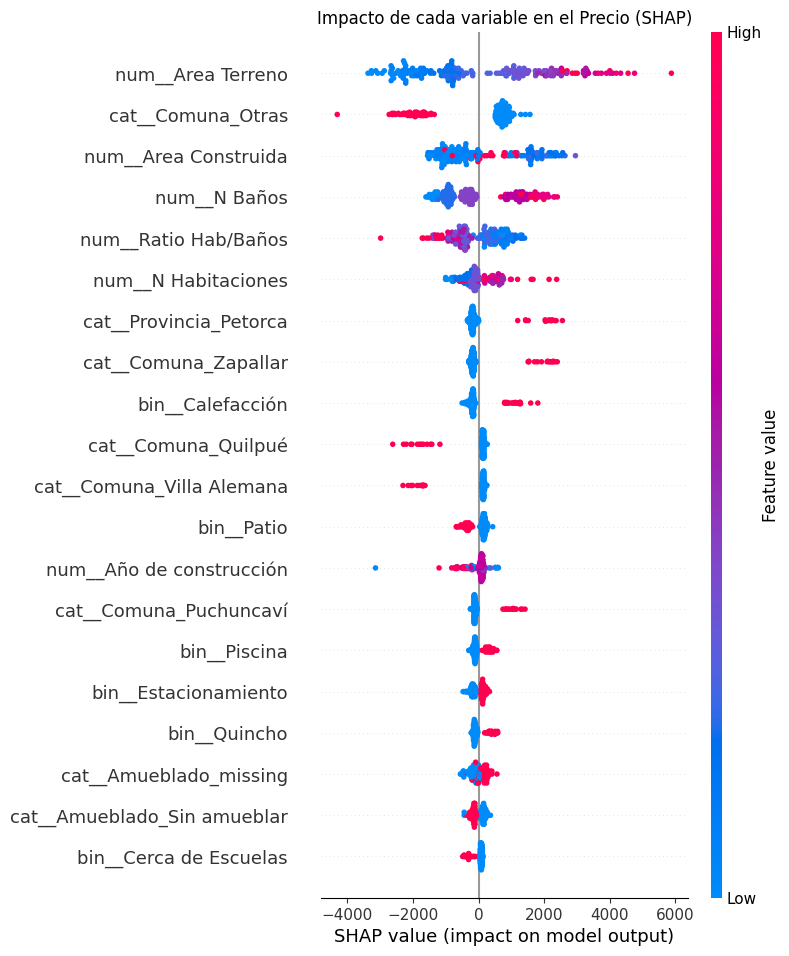

In [29]:
import matplotlib.pyplot as plt

# 1. Recuperar el mejor modelo y el preprocesador del pipeline optimizado
# (Asumiendo que 'random_search' es tu objeto final del paso anterior)
best_pipeline = random_search.best_estimator_
modelo_final = best_pipeline.named_steps['model']
preprocesador_final = best_pipeline.named_steps['preprocessor']

# 2. Transformar los datos de test para que SHAP los entienda
# SHAP necesita los números, no las categorías crudas
X_test_transformed = preprocesador_final.transform(X_test)

# 3. Obtener los nombres de las columnas transformadas (Opcional, pero recomendado para entender el gráfico)
# Esto recupera nombres como "Comuna_Valparaiso", "Comuna_Viña", etc.
feature_names = preprocesador_final.get_feature_names_out()

# Convertir a DataFrame para que SHAP muestre los nombres
X_test_shap = pd.DataFrame(X_test_transformed, columns=feature_names)

# 4. Crear el Explainer de SHAP
# TreeExplainer es específico y rápido para árboles (Random Forest, XGBoost, GradientBoosting)
explainer = shap.TreeExplainer(modelo_final)
shap_values = explainer.shap_values(X_test_shap)

# 5. Visualizar
# Gráfico de resumen (El más famoso)
plt.figure()
shap.summary_plot(shap_values, X_test_shap, show=False)
plt.title("Impacto de cada variable en el Precio (SHAP)")
plt.show()

* El Area de Terreno es la caracteristica mas influyente en el precio.
* El lugar de la vivienda (Comuna) influye bastante en el precio 

C:\Users\sebit\AppData\Local\Temp\ipykernel_8956\3373493518.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=df_importancia.head(20), palette='viridis')


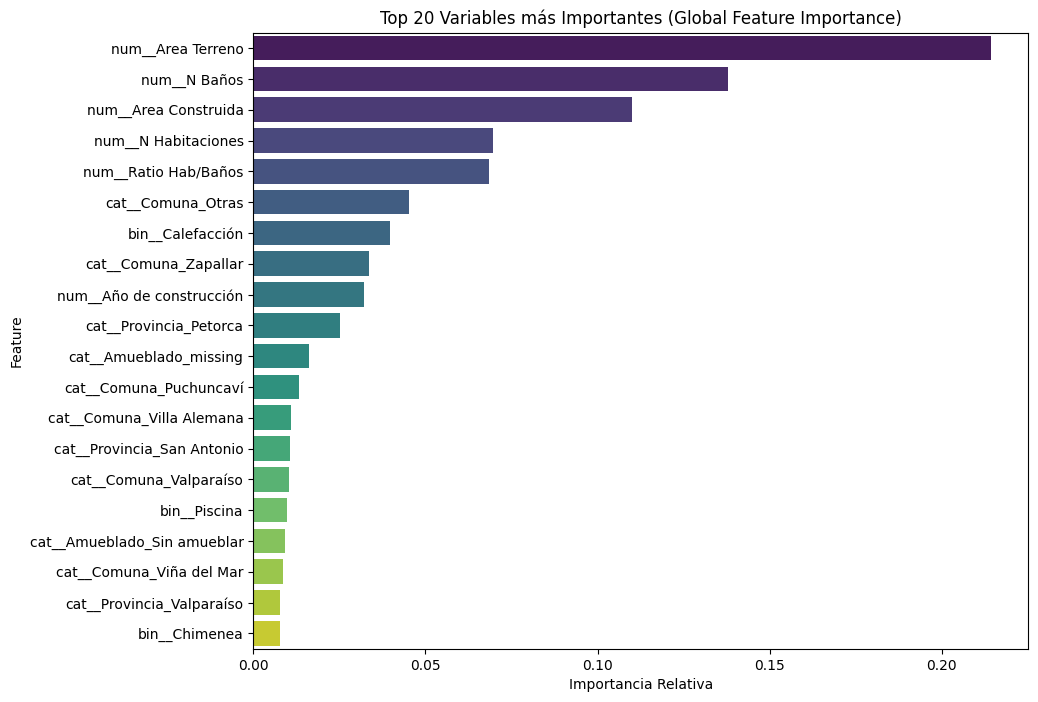

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer el mejor modelo y el preprocesador del RandomSearch
best_pipeline = random_search.best_estimator_
modelo_final = best_pipeline.named_steps['model']
preprocesador = best_pipeline.named_steps['preprocessor']

# 2. Obtener los nombres de las características transformadas
# Esto es vital porque OneHotEncoder creó muchas columnas nuevas (ej. Comuna_Valpo, Comuna_Viña)
feature_names = preprocesador.get_feature_names_out()

# 3. Obtener las importancias del modelo (Gradient Boosting las calcula nativamente)
importancias = modelo_final.feature_importances_

# 4. Crear un DataFrame para ordenar y visualizar
df_importancia = pd.DataFrame({
    'Feature': feature_names,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# 5. Visualizar el Top 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Feature', data=df_importancia.head(20), palette='viridis')
plt.title('Top 20 Variables más Importantes (Global Feature Importance)')
plt.xlabel('Importancia Relativa')
plt.show()

El modelo utiliza en gran medida las Areas, N habitaciones y baños y comunas para hacer las predicciones.